# Cell Operation with pET19K_MaSp1_4 

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the MaSp1 Transcription Reaction

Complete the steps necessary to create the MaSp1 Transcription Reaction

In [4]:
locus_id = 'MaSp1'
left_pos =  None
right_pos = None
seq = 'ATGACCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGAGGG'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_MaSp1', {'MaSp1'}, seq)
print(me.reactions.transcription_TU_MaSp1.reaction)
me.reactions.transcription_TU_MaSp1.update()

717 atp_c + 1950 ctp_c + 882 gtp_c + 567 utp_c --> RNA_MaSp1 + 1305.062631936 mRNA_biomass + 4116 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the MaSp1 Transcription Reaction

In [5]:
me.reactions.transcription_TU_MaSp1.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_MaSp1.update()

List the transcription data ("transcription_data") associated with the MaSp1 transcription reaction ("transcription_TU_MaSp1").

In [6]:
rxn = me.reactions.transcription_TU_MaSp1
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_MaSp1
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_MaSp1'}
nucleotide_sequence,ATGACCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCA...
RNA_products,{'RNA_MaSp1'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the MaSp1 transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_MaSp1
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_MaSp1
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7f9a8ca52400>: -0.019669844765619*mu - 0.00770074422573985, <TranscribedGene RNA_MaSp1 at 0x7f9a8cb7cda0>: 1, <Metabolite utp_c at 0x7f9a8ca52e10>: -567, <Metabolite atp_c at 0x7f9a8ca529b0>: -717, <Metabolite ctp_c at 0x7f9a8ca52ef0>: -1950, <Metabolite gtp_c at 0x7f9a8c..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the MaSp1 transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_MaSp1').reaction

'0.019669844765619*mu + 0.00770074422573985 RNAP70-CPLX + 717 atp_c + 1950 ctp_c + 882 gtp_c + 567 utp_c --> RNA_MaSp1 + 1305.062631936 mRNA_biomass + 4116 ppi_c'

List the RNAP associated with the MaSp1 transcription reaction

In [9]:
me.reactions.transcription_TU_MaSp1.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the MaSp1 Translation Reaction

Complete all the steps necessary to create the MaSp1 Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('MaSp1', me, 'RNA_MaSp1', 'protein_MaSp1')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_MaSp1')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c


### Incorporate the ribosome

Add the ribosome to the reaction.

In [13]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_MaSp1.update()
print(me.reactions.translation_MaSp1.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c


### Add Subreactions to the MaSp1 model

Create the subreactions that represent elongation, initiation and termination

In [14]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('MaSp1').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('MaSp1').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('MaSp1').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_MaSp1.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_MaSp1


List the subreactions associated with MaSp1 translation reaction stored in the ProcessData.

In [15]:
me.process_data.get_by_id('MaSp1').subreactions

defaultdict(int,
            {'Tuf_gtp_regeneration': 1371.0,
             'FusA_mono_elongation': 1371.0,
             'thr_addition_at_ACC': 1,
             'gly_addition_at_GGU': 328,
             'ala_addition_at_GCA': 160,
             'gln_addition_at_CAG': 48,
             'tyr_addition_at_UAU': 28,
             'leu_addition_at_CUG': 28,
             'ser_addition_at_AGC': 8,
             'ala_addition_at_GCC': 52,
             'arg_addition_at_CGU': 16,
             'gly_addition_at_GGA': 105,
             'gln_addition_at_CAA': 76,
             'ala_addition_at_GCU': 120,
             'gly_addition_at_GGC': 144,
             'ser_addition_at_UCA': 12,
             'leu_addition_at_UUA': 24,
             'ala_addition_at_GCG': 72,
             'tyr_addition_at_UAC': 16,
             'leu_addition_at_CUU': 16,
             'ser_addition_at_AGU': 4,
             'arg_addition_at_CGC': 8,
             'gly_addition_at_GGG': 56,
             'ser_addition_at_UCU': 8,
             

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [16]:
me.process_data.get_by_id('MaSp1').subreactions_from_sequence

{'thr_addition_at_ACC': 1,
 'gly_addition_at_GGU': 328,
 'ala_addition_at_GCA': 160,
 'gln_addition_at_CAG': 48,
 'tyr_addition_at_UAU': 28,
 'leu_addition_at_CUG': 28,
 'ser_addition_at_AGC': 8,
 'ala_addition_at_GCC': 52,
 'arg_addition_at_CGU': 16,
 'gly_addition_at_GGA': 105,
 'gln_addition_at_CAA': 76,
 'ala_addition_at_GCU': 120,
 'gly_addition_at_GGC': 144,
 'ser_addition_at_UCA': 12,
 'leu_addition_at_UUA': 24,
 'ala_addition_at_GCG': 72,
 'tyr_addition_at_UAC': 16,
 'leu_addition_at_CUU': 16,
 'ser_addition_at_AGU': 4,
 'arg_addition_at_CGC': 8,
 'gly_addition_at_GGG': 56,
 'ser_addition_at_UCU': 8,
 'arg_addition_at_CGG': 8,
 'ser_addition_at_UCC': 12,
 'ser_addition_at_UCG': 4,
 'leu_addition_at_UUG': 12,
 'arg_addition_at_AGA': 4}

### Updating the MaSp1 translation reaction

In [17]:
translation_subreactions = me.process_data.MaSp1.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_MaSp1.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.MaSp1.subreactions[subreaction] = value
me.reactions.translation_MaSp1.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_MaSp1.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c

After adding tRNA subreaction
-----------------------------
10fthf_c + 2.72438972852433e-7*mu Def_mono_mod_1:fe2 + 1.803241

List the reactants associated with the MaSp1 translation reaction. In this list all the subreactions should be listed.

In [18]:
me.reactions.translation_MaSp1.reactants

[<Metabolite met__L_c at 0x7f9a8bd539b0>,
 <Metabolite h2o_c at 0x7f9a8ca52a58>,
 <Metabolite thr__L_c at 0x7f9a8bd53e48>,
 <Metabolite gly_c at 0x7f9a8bd53d30>,
 <Metabolite ala__L_c at 0x7f9a8bd53f98>,
 <Metabolite gln__L_c at 0x7f9a8bd602b0>,
 <Metabolite tyr__L_c at 0x7f9a8bd604a8>,
 <Metabolite leu__L_c at 0x7f9a8bd53b70>,
 <Metabolite ser__L_c at 0x7f9a8bd53ef0>,
 <Metabolite arg__L_c at 0x7f9a8bd53ac8>,
 <Ribosome ribosome at 0x7f9a8bd60588>,
 <TranscribedGene RNA_MaSp1 at 0x7f9a8cb7cda0>,
 <Metabolite atp_c at 0x7f9a8ca529b0>,
 <Complex RNA_degradosome at 0x7f9a8ca7a400>,
 <Complex Tsf_mono at 0x7f9a8bd79c88>,
 <Complex FusA_mono at 0x7f9a8bd79c50>,
 <Metabolite gtp_c at 0x7f9a8ca52fd0>,
 <GenericComponent generic_Tuf at 0x7f9a8bd60a90>,
 <GenerictRNA generic_tRNA_ACC_thr__L_c at 0x7f9a8bd6f710>,
 <GenerictRNA generic_tRNA_GGU_gly_c at 0x7f9a8bd60f98>,
 <GenerictRNA generic_tRNA_GCA_ala__L_c at 0x7f9a8bd6f0f0>,
 <GenerictRNA generic_tRNA_CAG_gln__L_c at 0x7f9a8bd6f630>,
 <Gener

This completes the creation of the translation reaction

## 6. Create Demand Reaction for MaSp1

In [19]:
new_reaction = cobrame.MEReaction('DM_protein_MaSp1')
me.add_reaction(new_reaction)

In [20]:
me.reactions.get_by_id('DM_protein_MaSp1').reaction = 'protein_MaSp1 ->'
me.reactions.get_by_id('DM_protein_MaSp1').reaction

'protein_MaSp1 --> '

In [21]:
rxn = me.reactions.DM_protein_MaSp1
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_MaSp1
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_MaSp1 at 0x7f9a8cb442e8>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


## 7. Test the MaSp1 ME Model

In [22]:
me.reactions.DM_protein_MaSp1.upper_bound = 0.00066
me.reactions.DM_protein_MaSp1.lower_bound = 0.00066
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.362721 seconds
Finished substituting S,lb,ub in 2.199301 seconds
Finished makeME_LP in 0.391651 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.213337 seconds
Finished makeME_LP in 0.358518 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 2.258813 seconds
Finished makeME_LP in 0.358543 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 2.234347 seconds
Finished makeME_LP in 0.358765 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 2.241415 seconds
Finished makeME_LP in 0.361906 seconds
Getting MINOS parameters from ME_NLP...
5 0.5 0.5 0.53125 0.53125 1
Finished substituting S,lb,ub in 2.238369 seconds
Finished makeME_LP in 0.356552 seconds
Getting MINOS parameters from ME_NLP...
6 

## 8. Identify and List the Fluxes Associated with the MaSp1 Transcription Lumped Reaction

The reaction id of the MaSp1 transcription reaction is "transcription_TU_MaSp1" and requires the "RNAP70-CPLX" metabolite (RNA polymerase) as one of its reactants and produces the mRNA metabolite "RNA_MaSp1". The "RNAP70-CPLX" is created by the "formation_RNAP70-CPLX" reaction. The default fluxes through these reaction are:

In [23]:
print('transcription_TU_MaSp1 =', me.reactions.get_by_id('transcription_TU_MaSp1').x)
print('formation_RNAP70-CPLX =', me.reactions.get_by_id('formation_RNAP70-CPLX').x)

transcription_TU_MaSp1 = 7.286353806848159e-06
formation_RNAP70-CPLX = 2.09487285726302e-06


## 9. Identify and List the Fluxes Associated with the MaSp1 Translation Lumped Reaction

The reaction id of the MaSp1 translation reaction is "translation_MaSp1" and requires the mRNA metabolite "RNA_MaSp1" as one of its reactants and produces the protein metabolite ("TranslatedGene") "protein_MaSp1". To begin with, let's look at the fluxes of the RNAPs (MaSp1 uses the "RNAP70-CPLX" RNAP).

In [24]:
print('formation_CPLX0-221 = ', me.reactions.get_by_id('formation_CPLX0-221').x)
print('formation_CPLX0-222 = ', me.reactions.get_by_id('formation_CPLX0-222').x)
print('formation_RNAPE-CPLX = ', me.reactions.get_by_id('formation_RNAPE-CPLX').x)
print('formation_RNAP32-CPLX = ', me.reactions.get_by_id('formation_RNAP32-CPLX').x)
print('formation_RNAP54-CPLX = ', me.reactions.get_by_id('formation_RNAP54-CPLX').x)
print('formation_RNAP70-CPLX = ', me.reactions.get_by_id('formation_RNAP70-CPLX').x)
print('formation_RNAPS-CPLX = ', me.reactions.get_by_id('formation_RNAPS-CPLX').x)

formation_CPLX0-221 =  0.0
formation_CPLX0-222 =  4.450401755807829e-09
formation_RNAPE-CPLX =  1.825950035311101e-09
formation_RNAP32-CPLX =  1.1993529336761226e-09
formation_RNAP54-CPLX =  9.089324294627025e-10
formation_RNAP70-CPLX =  2.09487285726302e-06
formation_RNAPS-CPLX =  4.763711442858525e-09


List the fluxes for the "SummaryVariable" reactions that are associated with the growth-rate ("biomass_dilution").

In [25]:
print('protein_biomass_to_biomass = ', me.reactions.get_by_id('protein_biomass_to_biomass').x)
print('mRNA_biomass_to_biomass = ', me.reactions.get_by_id('mRNA_biomass_to_biomass').x)
print('tRNA_biomass_to_biomass = ', me.reactions.get_by_id('tRNA_biomass_to_biomass').x)
print('rRNA_biomass_to_biomass = ', me.reactions.get_by_id('rRNA_biomass_to_biomass').x)
print('ncRNA_biomass_to_biomass = ', me.reactions.get_by_id('ncRNA_biomass_to_biomass').x)
print('DNA_biomass_to_biomass = ', me.reactions.get_by_id('DNA_biomass_to_biomass').x)
print('lipid_biomass_to_biomass = ', me.reactions.get_by_id('lipid_biomass_to_biomass').x)
print('constituent_biomass_to_biomass = ', me.reactions.get_by_id('constituent_biomass_to_biomass').x)
print('prosthetic_group_biomass_to_biomass = ', me.reactions.get_by_id('prosthetic_group_biomass_to_biomass').x)
print('peptidoglycan_biomass_to_biomass = ', me.reactions.get_by_id('peptidoglycan_biomass_to_biomass').x)
print('dummy_protein_to_mass = ', me.reactions.get_by_id('dummy_protein_to_mass').x)
print('biomass_constituent_demand = ', me.reactions.get_by_id('biomass_constituent_demand').x)
print('Demand_pe161_p = ', me.reactions.get_by_id('Demand_pe161_p').x)
print('Demand_pe160_p = ', me.reactions.get_by_id('Demand_pe160_p').x)
print('Demand_pe161_p = ', me.reactions.get_by_id('Demand_pe161_p').x)
print('Demand_pe161_c = ', me.reactions.get_by_id('Demand_pe161_c').x)
print('Demand_pe160_c = ', me.reactions.get_by_id('Demand_pe160_c').x)
print('Demand_kdo2lipid4_e = ', me.reactions.get_by_id('Demand_kdo2lipid4_e').x)

protein_biomass_to_biomass =  0.2054495857323744
mRNA_biomass_to_biomass =  0.0013691392312444946
tRNA_biomass_to_biomass =  0.008311108654429432
rRNA_biomass_to_biomass =  0.05959917277024244
ncRNA_biomass_to_biomass =  5.688558031059614e-05
DNA_biomass_to_biomass =  0.02274339861179544
lipid_biomass_to_biomass =  0.06811700238117673
constituent_biomass_to_biomass =  0.012984775496357535
prosthetic_group_biomass_to_biomass =  0.00026109315064114886
peptidoglycan_biomass_to_biomass =  0.01335494641696719
dummy_protein_to_mass =  0.0034281816134569707
biomass_constituent_demand =  0.5078125
Demand_pe161_p =  0.5078125
Demand_pe160_p =  0.5078125
Demand_pe161_p =  0.5078125
Demand_pe161_c =  0.5078125
Demand_pe160_c =  0.5078125
Demand_kdo2lipid4_e =  0.5078125


### Find the amino acid count

In [26]:
me.process_data.MaSp1.amino_acid_count

defaultdict(int,
            {'met__L_c': 1,
             'thr__L_c': 1,
             'gly_c': 634,
             'ala__L_c': 404,
             'gln__L_c': 124,
             'tyr__L_c': 44,
             'leu__L_c': 80,
             'ser__L_c': 48,
             'arg__L_c': 36})

## 10. Tracking the tRNA flux

From these amino acid counts it can be seen that glycine and alanine are the two amino acids that dominate the production of MaSp1. Let's track the impact of the tRNA production of the reactions that charge the tRNA. 

### Reactions that create charged tRNA metabolites for both Glycine

There are four different codons that can be used to create glycine tRNA. The metabolites associated with these glycine codons are

#### Glycine Charged tRNA Metabolites
1. generic_tRNA_GGC_gly_c
- generic_tRNA_GGU_gly_c
- generic_tRNA_GGG_gly_c
- generic_tRNA_GGA_gly_c

#### Glycine tRNA Charging Reactions
The reactions, based on codons, that create these charged tRNA metabolites are

##### GGC
1. charging_tRNA_b1911_GGC
- charging_tRNA_b4163_GGC
- charging_tRNA_b4164_GGC
- charging_tRNA_b4165_GGC

##### GGU
1.  charging_tRNA_b1911_GGU
- charging_tRNA_b4163_GGU
- charging_tRNA_b4164_GGU
- charging_tRNA_b4165_GGU

##### GGG
1.  charging_tRNA_b2864_GGG

##### GGA
1. charging_tRNA_b3978_GGA

Note that there are six different reactions that create these glycine tRNA metabolites. Also note that there are two reactions that create the glycine tRNA for three of the codons.

### Simulating the growth-rate based on the production of MaSp1

In [27]:
MaSp1_protein = [0.000000, 0.00001, 0.00005, 0.0001, 0.0005, 0.0006, 0.00066]
growth_rate = []
transcription_rate = []
translation_rate = []
ribosome_rate = []
ribosome_shadow_price = []
acetate_rate = []
ATP_flux = []

# Summary Variables
protein_biomass_to_biomass_data = []
mRNA_biomass_to_biomass_data = []
tRNA_biomass_to_biomass_data = []
prosthetic_group_biomass_to_biomass_data = []
dummy_protein_to_mass_data = []

# Glycine tRNA
charging_tRNA_b1911_GGC_data = []
charging_tRNA_b4163_GGC_data = []
charging_tRNA_b4164_GGC_data = []
charging_tRNA_b4165_GGC_data = []
charging_tRNA_b1911_GGU_data = []
charging_tRNA_b4163_GGU_data = []
charging_tRNA_b4164_GGU_data = []
charging_tRNA_b4165_GGU_data = []
charging_tRNA_b2864_GGG_data = []
charging_tRNA_b3978_GGA_data = []

# Alanine tRNA
charging_tRNA_b0203_GCA_data = []
charging_tRNA_b3276_GCA_data = []
charging_tRNA_b3853_GCA_data = []
charging_tRNA_b0203_GCG_data = []
charging_tRNA_b3276_GCG_data = []
charging_tRNA_b3853_GCG_data = []
charging_tRNA_b0203_GCU_data = []
charging_tRNA_b3276_GCU_data = []
charging_tRNA_b3853_GCU_data = []
charging_tRNA_b2396_GCC_data = []  
charging_tRNA_b2397_GCC_data = [] 

# Cell Operation
glucose_data = []
oxygen_data = []
acetate_data = []
ammonium_data = []
external_protons_data = []
atp_synthase = []
ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data = []
ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data = []
ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data = []
ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data = []

for x in MaSp1_protein:
    print('\nMaSp1 Protein # ',x)
    me.reactions.DM_protein_MaSp1.upper_bound = x
    me.reactions.DM_protein_MaSp1.lower_bound = x
    solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)
    growth_rate.append(me.solution.f)
    transcription_rate.append(me.reactions.transcription_TU_MaSp1.x)
    translation_rate.append(me.reactions.translation_MaSp1.x)
    ribosome_rate.append(me.reactions.get_by_id('formation_ribosome').x)
    ribosome_shadow_price.append(me.metabolites.get_by_id('ribosome').y)
    acetate_rate.append(me.reactions.get_by_id('EX_ac_e').x)
    ATP_flux.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2').x)
    # Glycine tRNA
    charging_tRNA_b1911_GGC_data.append(me.reactions.charging_tRNA_b1911_GGC.x)
    charging_tRNA_b4163_GGC_data.append(me.reactions.charging_tRNA_b4163_GGC.x)
    charging_tRNA_b4164_GGC_data.append(me.reactions.charging_tRNA_b4164_GGC.x)
    charging_tRNA_b4165_GGC_data.append(me.reactions.charging_tRNA_b4165_GGC.x)
    charging_tRNA_b1911_GGU_data.append(me.reactions.charging_tRNA_b1911_GGU.x)
    charging_tRNA_b4163_GGU_data.append(me.reactions.charging_tRNA_b4163_GGU.x)
    charging_tRNA_b4164_GGU_data.append(me.reactions.charging_tRNA_b4164_GGU.x)
    charging_tRNA_b4165_GGU_data.append(me.reactions.charging_tRNA_b4165_GGU.x)
    charging_tRNA_b2864_GGG_data.append(me.reactions.charging_tRNA_b2864_GGG.x)
    charging_tRNA_b3978_GGA_data.append(me.reactions.charging_tRNA_b3978_GGA.x)
    # Alanine tRNA
    charging_tRNA_b0203_GCA_data.append(me.reactions.charging_tRNA_b0203_GCA.x)
    charging_tRNA_b3276_GCA_data.append(me.reactions.charging_tRNA_b3276_GCA.x)
    charging_tRNA_b3853_GCA_data.append(me.reactions.charging_tRNA_b3853_GCA.x)
    charging_tRNA_b0203_GCG_data.append(me.reactions.charging_tRNA_b0203_GCG.x)
    charging_tRNA_b3276_GCG_data.append(me.reactions.charging_tRNA_b3276_GCG.x)
    charging_tRNA_b3853_GCG_data.append(me.reactions.charging_tRNA_b3853_GCG.x)
    charging_tRNA_b0203_GCU_data.append(me.reactions.charging_tRNA_b0203_GCU.x)
    charging_tRNA_b3276_GCU_data.append(me.reactions.charging_tRNA_b3276_GCU.x)
    charging_tRNA_b3853_GCU_data.append(me.reactions.charging_tRNA_b3853_GCU.x)
    charging_tRNA_b2396_GCC_data.append(me.reactions.charging_tRNA_b2396_GCC.x)  
    charging_tRNA_b2397_GCC_data.append(me.reactions.charging_tRNA_b2397_GCC.x) 
    # Cell operation
    glucose_data.append(me.reactions.get_by_id('EX_glc__D_e').x)
    oxygen_data.append(me.reactions.get_by_id('EX_o2_e').x)
    acetate_data.append(me.reactions.get_by_id('EX_ac_e').x)
    ammonium_data.append(me.reactions.get_by_id('EX_nh4_e').x)
    external_protons_data.append(me.reactions.get_by_id('EX_h_e').x)
    ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_REV_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)
    ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)
    ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_REV_ATPSYN-CPLX_mod_mg2').x)
    ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2').x)
    #atp_synthase.append(me.reactions.get_by_id(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)
    protein_biomass_to_biomass_data.append(me.reactions.get_by_id('protein_biomass_to_biomass').x)
    mRNA_biomass_to_biomass_data.append(me.reactions.get_by_id('mRNA_biomass_to_biomass').x)
    tRNA_biomass_to_biomass_data.append(me.reactions.get_by_id('tRNA_biomass_to_biomass').x)
    prosthetic_group_biomass_to_biomass_data.append(me.reactions.get_by_id('prosthetic_group_biomass_to_biomass').x)
    dummy_protein_to_mass_data.append(me.reactions.get_by_id('dummy_protein_to_mass').x)

print('Growth-rate =', growth_rate)
print('Transcription Rate =', transcription_rate)
print('Translation Rate =', translation_rate)


MaSp1 Protein #  0.0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 33.211409 seconds
Finished substituting S,lb,ub in 2.186785 seconds
Finished makeME_LP in 0.354709 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.221362 seconds
Finished makeME_LP in 0.364040 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.262571 seconds
Finished makeME_LP in 0.358483 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.248515 seconds
Finished makeME_LP in 0.360159 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.260642 seconds
Finished makeME_LP in 0.360589 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.285732 seconds
Finished makeME_LP in 0.356668 se

Finished makeME_LP in 0.357955 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 2.273949 seconds
Finished makeME_LP in 0.356164 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 2.263038 seconds
Finished makeME_LP in 0.359747 seconds
Getting MINOS parameters from ME_NLP...
5 0.5 0.5 0.53125 0.53125 1
Finished substituting S,lb,ub in 2.256933 seconds
Finished makeME_LP in 0.361151 seconds
Getting MINOS parameters from ME_NLP...
6 0.5 0.5 0.515625 0.515625 1
Finished substituting S,lb,ub in 2.248666 seconds
Finished makeME_LP in 0.355177 seconds
Getting MINOS parameters from ME_NLP...
7 0.5078125 0.5078125 0.515625 0.5078125 optimal
Bisection done in 118.49 seconds
Growth-rate = [0.828125, 0.828125, 0.8125, 0.796875, 0.6328125, 0.5703125, 0.5078125]
Transcription Rate = [0.0, 9.416105600417562e-08, 4.7313460659139674e-07, 9.511410977971434e-07, 5.0957157350251495e-06, 6.339464

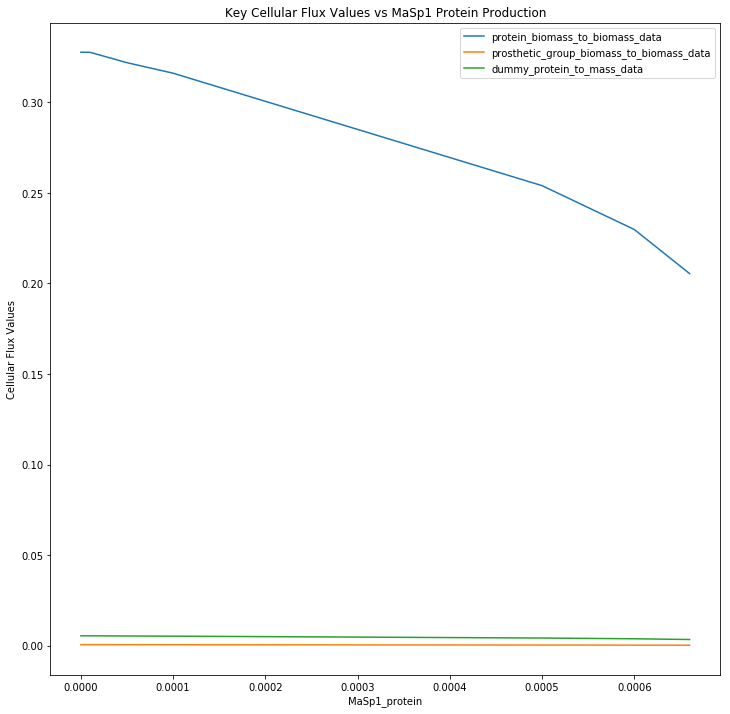

In [28]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, protein_biomass_to_biomass_data, label = "protein_biomass_to_biomass_data")
#plt.plot(x, mRNA_biomass_to_biomass_data, label = "mRNA_biomass_to_biomass_data")
#plt.plot(x, tRNA_biomass_to_biomass_data, label = "tRNA_biomass_to_biomass_data")
plt.plot(x, prosthetic_group_biomass_to_biomass_data, label = "prosthetic_group_biomass_to_biomass_data")
plt.plot(x, dummy_protein_to_mass_data, label = "dummy_protein_to_mass_data")
#plt.plot(x, external_protons_data, label = "external_protons_data")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Cellular Flux Values')
  
# giving a title to my graph
plt.title('Key Cellular Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

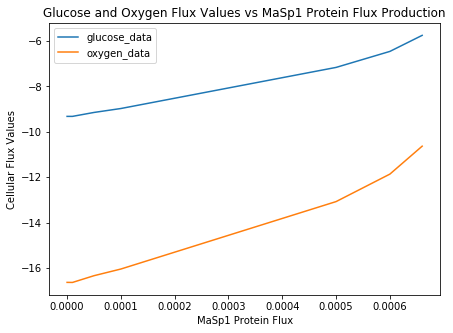

In [29]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, glucose_data, label = "glucose_data")
plt.plot(x, oxygen_data, label = "oxygen_data")

# naming the x axis
plt.xlabel('MaSp1 Protein Flux')
# naming the y axis
plt.ylabel('Cellular Flux Values')
  
# giving a title to my graph
plt.title('Glucose and Oxygen Flux Values vs MaSp1 Protein Flux Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

In [30]:
glucose_data

[-9.32345814320908,
 -9.323290078031697,
 -9.150341731549958,
 -8.97683764752429,
 -7.167999747048872,
 -6.4636638645768505,
 -5.757200380240502]

In [31]:
oxygen_data

[-16.62889701481881,
 -16.63216487181162,
 -16.335343165369206,
 -16.04133987620546,
 -13.073332557695451,
 -11.863688311954942,
 -10.634343708046528]

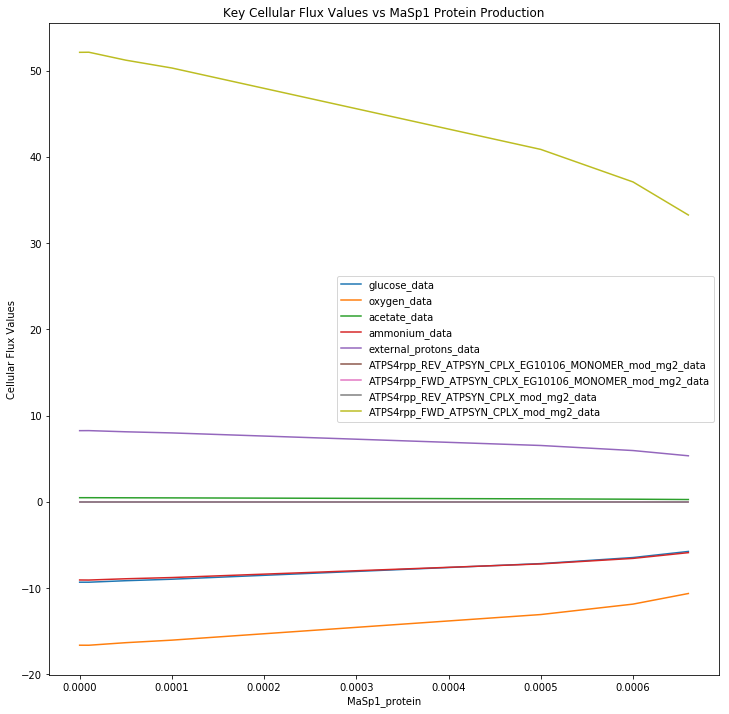

In [32]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, glucose_data, label = "glucose_data")
plt.plot(x, oxygen_data, label = "oxygen_data")
plt.plot(x, acetate_data, label = "acetate_data")
plt.plot(x, ammonium_data, label = "ammonium_data")

plt.plot(x, external_protons_data, label = "external_protons_data")
plt.plot(x, ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data, label = "ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data")
plt.plot(x, ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data, label = "ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data")
plt.plot(x, ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data, label = "ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data")
plt.plot(x, ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data, label = "ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Cellular Flux Values')
  
# giving a title to my graph
plt.title('Key Cellular Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

### Plot the growth-rate with respect to MaSp1 production

#### Plotting the flux of the individual tRNA charging reactions

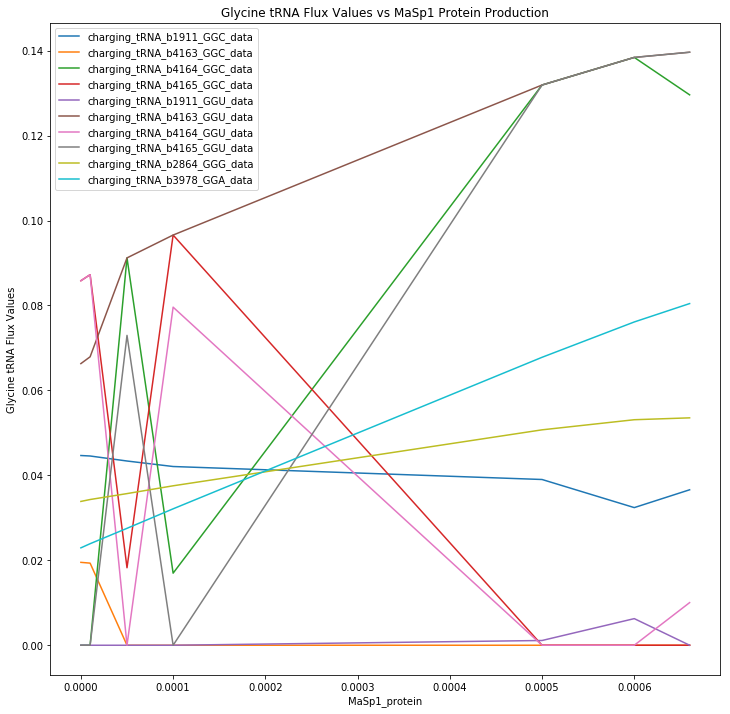

In [33]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, charging_tRNA_b1911_GGC_data, label = "charging_tRNA_b1911_GGC_data")
plt.plot(x, charging_tRNA_b4163_GGC_data, label = "charging_tRNA_b4163_GGC_data")
plt.plot(x, charging_tRNA_b4164_GGC_data, label = "charging_tRNA_b4164_GGC_data")
plt.plot(x, charging_tRNA_b4165_GGC_data, label = "charging_tRNA_b4165_GGC_data")

plt.plot(x, charging_tRNA_b1911_GGU_data, label = "charging_tRNA_b1911_GGU_data")
plt.plot(x, charging_tRNA_b4163_GGU_data, label = "charging_tRNA_b4163_GGU_data")
plt.plot(x, charging_tRNA_b4164_GGU_data, label = "charging_tRNA_b4164_GGU_data")
plt.plot(x, charging_tRNA_b4165_GGU_data, label = "charging_tRNA_b4165_GGU_data")

plt.plot(x, charging_tRNA_b2864_GGG_data, label = "charging_tRNA_b2864_GGG_data")
plt.plot(x, charging_tRNA_b3978_GGA_data, label = "charging_tRNA_b3978_GGA_data")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Glycine tRNA Flux Values')
  
# giving a title to my graph
plt.title('Glycine tRNA Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the codon-related flux

GGC =  [0.15002752 0.15115401 0.15283918 0.15564899 0.17094823 0.17082855
 0.16620881]
GGU =  [0.1521538  0.15517604 0.16417375 0.17619759 0.26495559 0.28310444
 0.28931451]
GGG =  [0.0338643092219749, 0.03431362287346766, 0.03570867112108025, 0.03754480874225784, 0.050723919419241606, 0.053103706254863534, 0.05354513494733479]
GGA =  [0.0229336005179359, 0.023909398191582776, 0.027531130183152532, 0.03212357284285286, 0.06780284739969121, 0.0761244038868823, 0.08045190579244864]


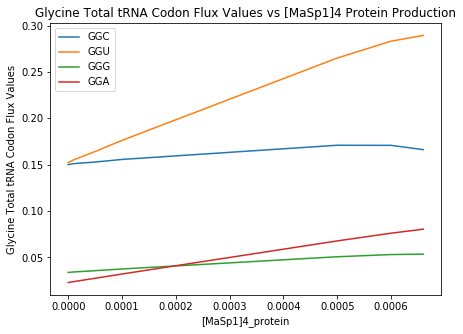

In [34]:
import numpy as np

GGC = [charging_tRNA_b1911_GGC_data, charging_tRNA_b4163_GGC_data, charging_tRNA_b4164_GGC_data, 
          charging_tRNA_b4165_GGC_data]
GGC = sum(map(np.array, GGC))
print('GGC = ', GGC)

GGU = [charging_tRNA_b1911_GGU_data, charging_tRNA_b4163_GGU_data, charging_tRNA_b4164_GGU_data,  
       charging_tRNA_b4165_GGU_data]
GGU = sum(map(np.array, GGU))
print('GGU = ', GGU)

GGG = charging_tRNA_b2864_GGG_data
print('GGG = ', GGG)

GGA = charging_tRNA_b3978_GGA_data
print('GGA = ', GGA)

# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, GGC, label = "GGC")
plt.plot(x, GGU, label = "GGU")
plt.plot(x, GGG, label = "GGG")
plt.plot(x, GGA, label = "GGA")

# naming the x axis
plt.xlabel('[MaSp1]4_protein')
# naming the y axis
plt.ylabel('Glycine Total tRNA Codon Flux Values')
  
# giving a title to my graph
plt.title('Glycine Total tRNA Codon Flux Values vs [MaSp1]4 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the charging reaction flux

b1911_data =  [0.04467434 0.04456275 0.04338167 0.04208587 0.04014695 0.03867921
 0.0366057 ]
b4163_data =  [0.08583566 0.08725577 0.09121042 0.0965869  0.13191896 0.13841793
 0.13963921]
b4164_data =  [0.08583566 0.08725577 0.09121042 0.0965869  0.13191896 0.13841793
 0.13963921]
b4165_data =  [0.08583566 0.08725577 0.09121042 0.0965869  0.13191896 0.13841793
 0.13963921]
b2864_data =  [0.0338643092219749, 0.03431362287346766, 0.03570867112108025, 0.03754480874225784, 0.050723919419241606, 0.053103706254863534, 0.05354513494733479]
b3978_data =  [0.0229336005179359, 0.023909398191582776, 0.027531130183152532, 0.03212357284285286, 0.06780284739969121, 0.0761244038868823, 0.08045190579244864]


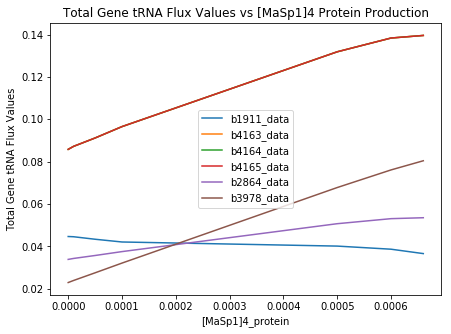

In [35]:
import numpy as np

b1911_data = [charging_tRNA_b1911_GGC_data, charging_tRNA_b1911_GGU_data]
b1911_data = sum(map(np.array, b1911_data))
print('b1911_data = ', b1911_data)

b4163_data = [charging_tRNA_b4163_GGC_data, charging_tRNA_b4163_GGU_data]
b4163_data = sum(map(np.array, b4163_data))
print('b4163_data = ', b4163_data)

b4164_data = [charging_tRNA_b4164_GGC_data, charging_tRNA_b4164_GGU_data]
b4164_data = sum(map(np.array, b4164_data))
print('b4164_data = ', b4164_data)

b4165_data = [charging_tRNA_b4165_GGC_data, charging_tRNA_b4165_GGU_data]
b4165_data = sum(map(np.array, b4165_data))
print('b4165_data = ', b4165_data)

b2864_data = charging_tRNA_b2864_GGG_data
print('b2864_data = ', b2864_data)

b3978_data = charging_tRNA_b3978_GGA_data
print('b3978_data = ', b3978_data)

# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, b1911_data, label = "b1911_data")
plt.plot(x, b4163_data, label = "b4163_data")
plt.plot(x, b4164_data, label = "b4164_data")
plt.plot(x, b4165_data, label = "b4165_data")
plt.plot(x, b2864_data, label = "b2864_data")
plt.plot(x, b3978_data, label = "b3978_data")

# naming the x axis
plt.xlabel('[MaSp1]4_protein')
# naming the y axis
plt.ylabel('Total Gene tRNA Flux Values')
  
# giving a title to my graph
plt.title('Total Gene tRNA Flux Values vs [MaSp1]4 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

### Reactions that create charged tRNA metabolites for both Alanine

There are four different codons that can be used to create alanine tRNA. The metabolites associated with these alanine codons are

### Alanine tRNA Charged Metabolites
1. generic_tRNA_GCA_ala__L_c
- generic_tRNA_GCG_ala__L_c
- generic_tRNA_GCU_ala__L_c
- generic_tRNA_GCC_ala__L_c

### Alanine tRNA Charging Reactions
The reactions, based on codons, that create these charged tRNA metabolites are

##### GCA
1. charging_tRNA_b0203_GCA
- charging_tRNA_b3276_GCA
- charging_tRNA_b3853_GCA

##### GCG
1. charging_tRNA_b0203_GCG
- charging_tRNA_b3276_GCG
- charging_tRNA_b3853_GCG

##### GCU
1. charging_tRNA_b0203_GCU
- charging_tRNA_b3276_GCU
- charging_tRNA_b3853_GCU

##### GCC
1. charging_tRNA_b2396_GCC
- charging_tRNA_b2397_GCC

Note that there are five different reactions that create these alanine tRNA metabolites. Also note that there are three reactions that create the alanine tRNA for three of the codons.

#### Plotting the flux of the individual alanine tRNA charging reactions

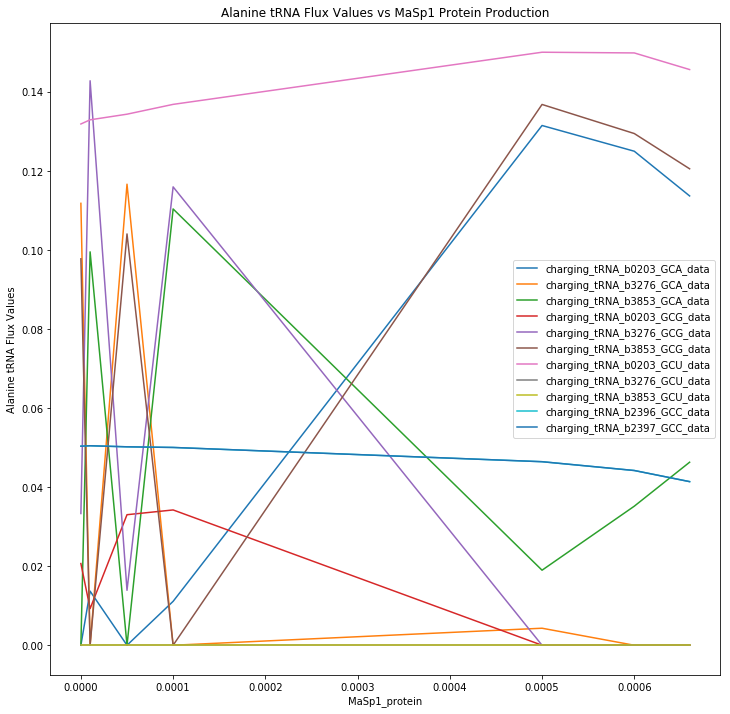

In [36]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, charging_tRNA_b0203_GCA_data, label = "charging_tRNA_b0203_GCA_data")
plt.plot(x, charging_tRNA_b3276_GCA_data, label = "charging_tRNA_b3276_GCA_data")
plt.plot(x, charging_tRNA_b3853_GCA_data, label = "charging_tRNA_b3853_GCA_data")

plt.plot(x, charging_tRNA_b0203_GCG_data, label = "charging_tRNA_b0203_GCG_data")
plt.plot(x, charging_tRNA_b3276_GCG_data, label = "charging_tRNA_b3276_GCG_data")
plt.plot(x, charging_tRNA_b3853_GCG_data, label = "charging_tRNA_b3853_GCG_data")

plt.plot(x, charging_tRNA_b0203_GCU_data, label = "charging_tRNA_b0203_GCU_data")
plt.plot(x, charging_tRNA_b3276_GCU_data, label = "charging_tRNA_b3276_GCU_data")
plt.plot(x, charging_tRNA_b3853_GCU_data, label = "charging_tRNA_b3853_GCU_data")

plt.plot(x, charging_tRNA_b2396_GCC_data, label = "charging_tRNA_b2396_GCC_data")
plt.plot(x, charging_tRNA_b2397_GCC_data, label = "charging_tRNA_b2397_GCC_data")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the codon-related flux

GCA =  [0.11178709 0.11318767 0.11662853 0.12146961 0.1547645  0.16014493
 0.15996078]
GCG =  [0.15173974 0.15206226 0.15096785 0.15017912 0.13680133 0.1294466
 0.1205259 ]
GCU =  [0.13186192 0.13291651 0.13433973 0.13682324 0.15001474 0.1498357
 0.14563297]
GCC =  [0.10070662 0.10093025 0.10039629 0.10007035 0.09286051 0.08840727
 0.0827791 ]
total =  [0.49609537 0.4990967  0.50233241 0.50854232 0.53444108 0.52783451
 0.50889875]


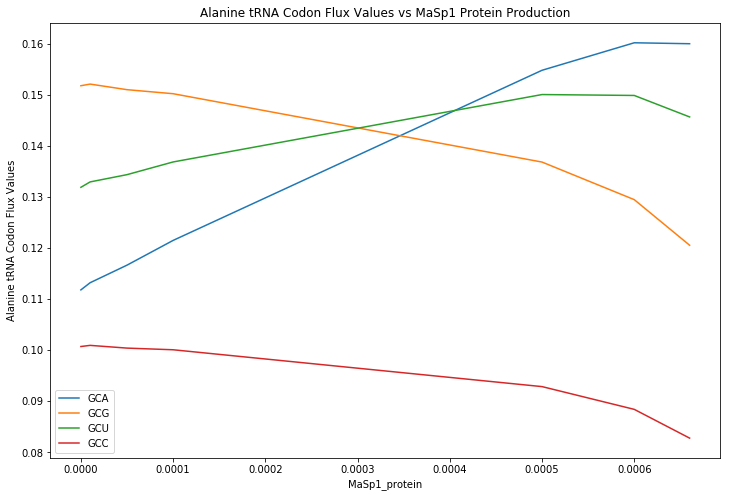

In [37]:
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,8))

GCA = [charging_tRNA_b0203_GCA_data, charging_tRNA_b3276_GCA_data, charging_tRNA_b3853_GCA_data]
GCA = sum(map(np.array, GCA))
print('GCA = ', GCA)

GCG = [charging_tRNA_b0203_GCG_data, charging_tRNA_b3276_GCG_data, charging_tRNA_b3853_GCG_data]
GCG = sum(map(np.array, GCG))
print('GCG = ', GCG)

GCU = [charging_tRNA_b0203_GCU_data, charging_tRNA_b3276_GCU_data, charging_tRNA_b3853_GCU_data]
GCU = sum(map(np.array, GCU))
print('GCU = ', GCU)

GCC = [charging_tRNA_b2396_GCC_data, charging_tRNA_b2397_GCC_data]
GCC = sum(map(np.array, GCC))
print('GCC = ', GCC)

total = [GCA, GCG, GCU, GCC]
total = sum(map(np.array, total))
print('total = ', total)

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, GCA, label = "GCA")
plt.plot(x, GCG, label = "GCG")
plt.plot(x, GCU, label = "GCU")
plt.plot(x, GCC, label = "GCC")
#plt.plot(x, total, label = "Total")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Codon Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Codon Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the reaction flux

b0203 =  [0.15252988 0.15586115 0.16736105 0.18215445 0.2814921  0.27480616
 0.25929334]
b3276 =  [0.14510823 0.14279192 0.13052693 0.11595186 0.00430496 0.
 0.        ]
b3853 =  [0.09775063 0.09951338 0.10404813 0.11036565 0.1557835  0.16462108
 0.16682631]
b2396 =  [0.05035331 0.05046513 0.05019815 0.05003518 0.04643026 0.04420364
 0.04138955]
b2397 =  [0.05035331 0.05046513 0.05019815 0.05003518 0.04643026 0.04420364
 0.04138955]
total =  [0.49609537 0.4990967  0.50233241 0.50854232 0.53444108 0.52783451
 0.50889875]


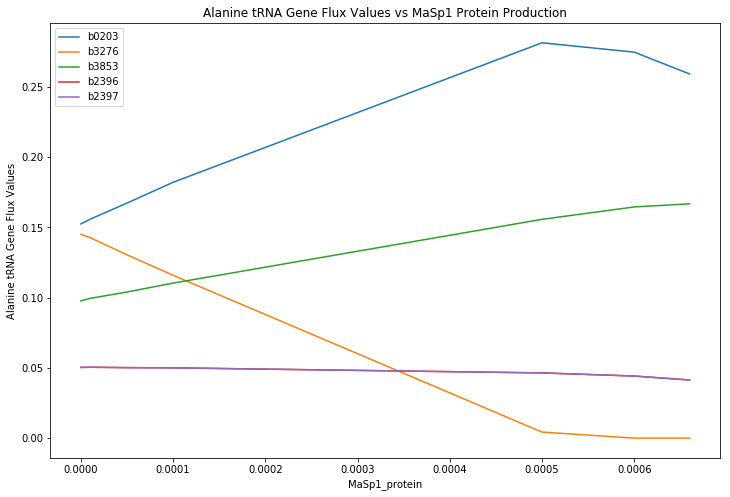

In [38]:
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,8))

b0203 = [charging_tRNA_b0203_GCA_data, charging_tRNA_b0203_GCG_data, charging_tRNA_b0203_GCU_data]
b0203 = sum(map(np.array, b0203))
print('b0203 = ', b0203)

b3276 = [charging_tRNA_b3276_GCA_data, charging_tRNA_b3276_GCG_data, charging_tRNA_b3276_GCU_data]
b3276 = sum(map(np.array, b3276))
print('b3276 = ', b3276)

b3853 = [charging_tRNA_b3853_GCA_data, charging_tRNA_b3853_GCG_data, charging_tRNA_b3853_GCU_data]
b3853 = sum(map(np.array, b3853))
print('b3853 = ', b3853)

b2396 = [charging_tRNA_b2396_GCC_data]
b2396 = sum(map(np.array, b2396))
print('b2396 = ', b2396)

b2397 = [charging_tRNA_b2397_GCC_data]
b2397 = sum(map(np.array, b2397))
print('b2397 = ', b2397)

total = [b0203, b3276, b3853, b2396,b2397]
total = sum(map(np.array, total))
print('total = ', total)

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, b0203, label = "b0203")
plt.plot(x, b3276, label = "b3276")
plt.plot(x, b3853, label = "b3853")
plt.plot(x, b2396, label = "b2396")
plt.plot(x, b2397, label = "b2397")
#plt.plot(x, total, label = "total")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Gene Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Gene Flux Values vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the transcription, translation, and ribosome flux with respect to MaSp1 production

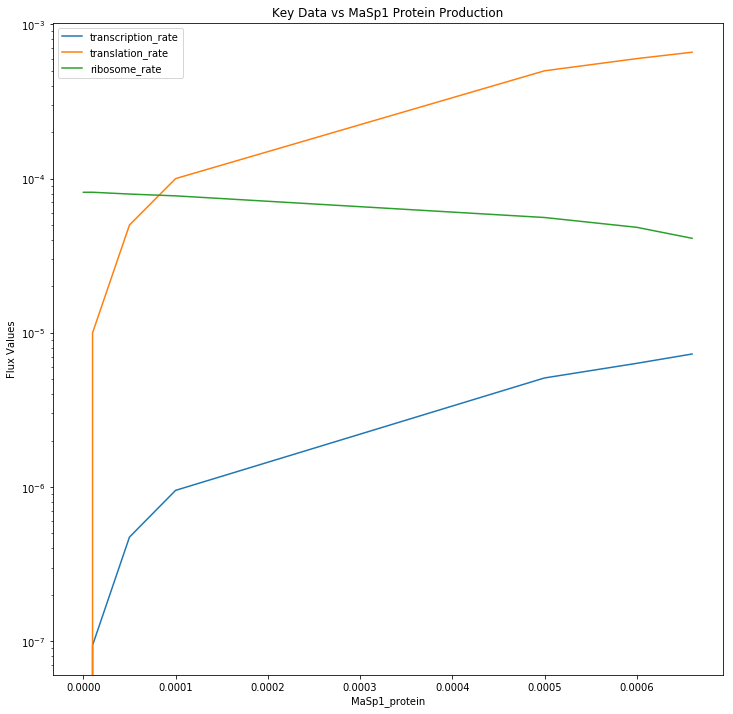

In [39]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, transcription_rate, label = "transcription_rate")
plt.plot(x, translation_rate, label = "translation_rate")
plt.plot(x, ribosome_rate, label = "ribosome_rate")
#plt.plot(x, ribosome_shadow_price, label = "ribosome_shadow_price")

# naming the x axis
plt.xlabel('MaSp1_protein')
# naming the y axis
plt.ylabel('Flux Values')
  
# giving a title to my graph
plt.title('Key Data vs MaSp1 Protein Production')
  
# function to show the plot
plt.legend()
plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to MaSp1 production

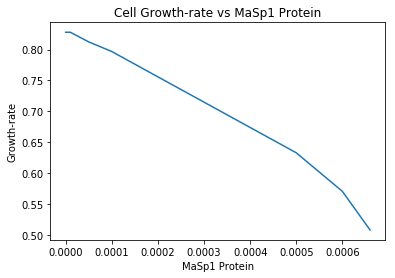

In [40]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the transcription flux with respect to MaSp1 production

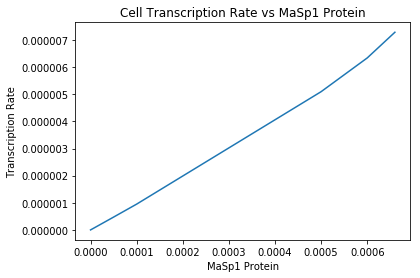

In [41]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = transcription_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Transcription Rate')
  
# giving a title to my graph
plt.title('Cell Transcription Rate vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the translation flux with respect to MaSp1 production

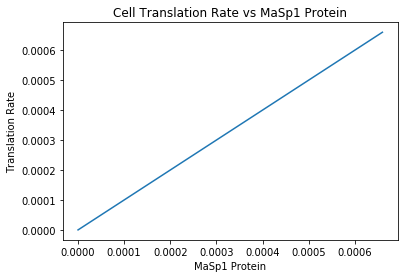

In [42]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = translation_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Translation Rate')
  
# giving a title to my graph
plt.title('Cell Translation Rate vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the ribosome flux with respect to MaSp1 production

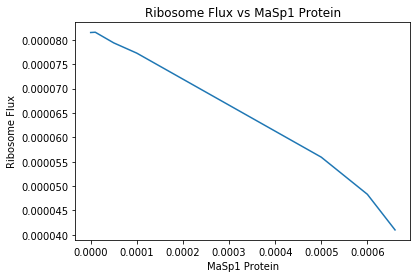

In [43]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = ribosome_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Ribosome Flux')
  
# giving a title to my graph
plt.title('Ribosome Flux vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the ribosome shadow prices with respect to MaSp1 production

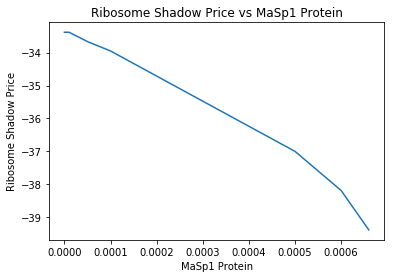

In [44]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = ribosome_shadow_price
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Ribosome Shadow Price')
  
# giving a title to my graph
plt.title('Ribosome Shadow Price vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the secreted acetate flux with respect to MaSp1 production

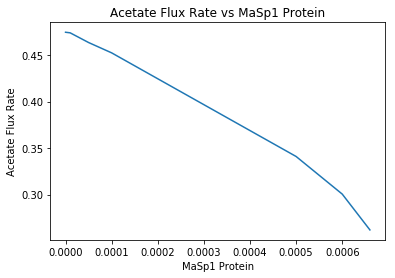

In [45]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = acetate_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('Acetate Flux Rate')
  
# giving a title to my graph
plt.title('Acetate Flux Rate vs MaSp1 Protein')
  
# function to show the plot
plt.show()

#### Plot the ATP production flux with respect to MaSp1 production

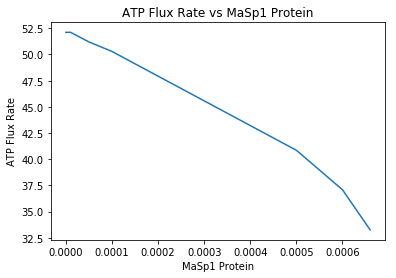

In [46]:
# x axis values
x = MaSp1_protein
# corresponding y axis values
y = ATP_flux
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 Protein')
# naming the y axis
plt.ylabel('ATP Flux Rate')
  
# giving a title to my graph
plt.title('ATP Flux Rate vs MaSp1 Protein')
  
# function to show the plot
plt.show()

In [47]:
show_escher_map(me).display_in_notebook()

/usr/lib/python3.6/site-packages/escher/plots.py:155 UserWarning: Map not in cache. Attempting download from https://escher.github.io/1-0-0/5/maps/Escherichia%20coli/iJO1366.Central%20metabolism.json


In [48]:
print('transcription_TU_MaSp1 =', me.reactions.get_by_id('transcription_TU_MaSp1').x)
print('formation_RNAP70-CPLX =', me.reactions.get_by_id('formation_RNAP70-CPLX').x)

transcription_TU_MaSp1 = 7.286353806848159e-06
formation_RNAP70-CPLX = 2.09487285726302e-06


In [49]:
me.metabolites.protein_MaSp1.reactions

frozenset({<MEReaction DM_protein_MaSp1 at 0x7f9a8cb4d550>,
           <TranslationReaction translation_MaSp1 at 0x7f9a8cb444e0>})

In [50]:
me.reactions.translation_MaSp1.x

0.00066